In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Image

In [2]:
def TDMAsolver(a, b, c, d):
    nf = len(d) # number of equations
    ac, bc, cc, dc = map(np.array, (a, b, c, d)) # copy arrays
    for it in range(1, nf):
        mc = ac[it-1]/bc[it-1]
        bc[it] = bc[it] - mc*cc[it-1] 
        dc[it] = dc[it] - mc*dc[it-1]

    xc = bc
    xc[-1] = dc[-1]/bc[-1]

    for il in range(nf-2, -1, -1):
        xc[il] = (dc[il]-cc[il]*xc[il+1])/bc[il]

    return xc

In [3]:
def rho(p):
    cf = 1e-4 # atm
    rho0 = 1000
    p0 = 120 # atm
    return rho0 * (1 + cf * (p - p0))

In [4]:
tau = 0.1 # days
h = 5 # meters
T = 10
L = 500
N = int(T/tau) + 1
M = int(L/h) + 1

# parameters
p_inj = 150 # atm
p_prod = 50 # atm
p_init = 100 # atm
k = 1e-14 # m^2
mu = 1/(1e8*3600*24) # atm*day
phi = 0.2
cf = 1e-4 # atm^-1
rho0 = 1000
p0 = 120 # atm


In [5]:
t = np.linspace(0, T, N)
x = np.linspace(0, L, M)
N,M

(101, 101)

In [6]:
p = np.zeros(shape=(N,M))

In [7]:
for i in range(len(p[0])):
    p[0][i] = p_init
p[0][0] = p_inj
p[0][M-1] = p_prod

In [8]:
# time loop
for i in range(1,N):
    # tdma coefficients
    a = np.zeros(M)
    b = np.zeros(M)
    c = np.zeros(M)
    d = np.zeros(M)
    for j in range(1, M-1):
        if j == 1:
            c[j] = k/mu/h**2 * rho(p[i-1][j])
            b[j] = k/mu/h**2 * rho(max(p[i-1][j],p[i-1][j+1]))
        elif j == M-2:
            c[j] = k/mu/h**2 * rho(max(p[i-1][j-1],p[i-1][j]))
            b[j] = k/mu/h**2 * rho(p[i-1][j])
        else:
            c[j] = k/mu/h**2 * rho(max(p[i-1][j-1],p[i-1][j]))
            b[j] = k/mu/h**2 * rho(max(p[i-1][j],p[i-1][j+1]))
        a[j] = -c[j] - b[j] - phi*cf*rho0/tau
        d[j] = -phi*cf*rho0/tau * p[i-1][j]

    a[0] = 1
    b[0] = 0
    a[-1] = 1
    c[-1] = 0
    d[0] = p_inj
    d[-1] = p_prod
    
    c = np.delete(c, 0)
    b = np.delete(b, -1)
    tmp = TDMAsolver(c,a,b,d)
    for j in range(M):
        p[i][j] = tmp[j]
    

In [9]:
p

array([[150.        , 100.        , 100.        , ..., 100.        ,
        100.        ,  50.        ],
       [150.        , 139.32252505, 130.92521952, ...,  69.07478048,
         60.67747495,  50.        ],
       [150.        , 144.03300095, 138.33807318, ...,  61.69968041,
         55.98873163,  50.        ],
       ...,
       [150.        , 149.00098811, 148.00198922, ...,  52.01472685,
         51.00742044,  50.        ],
       [150.        , 149.00119955, 148.00241129, ...,  52.0143484 ,
         51.0072308 ,  50.        ],
       [150.        , 149.00139807, 148.0028076 , ...,  52.01399522,
         51.00705382,  50.        ]])

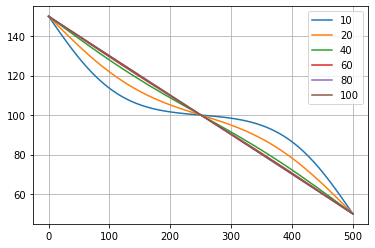

In [10]:
plots = [10,20,40,60,80,100]
labels = [str(x) for x in plots]
for ind,pl in enumerate(plots):
    plt.plot(x,p[pl],label=labels[ind])
plt.grid()
plt.legend()
plt.show()

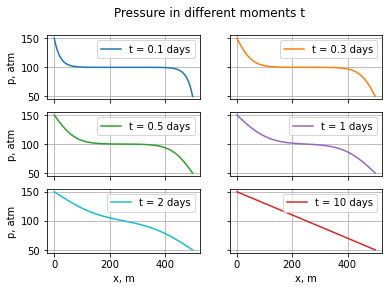

In [11]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2)
fig.suptitle('Pressure in different moments t')
ax1.plot(x, p[1], label='t = 0.1 days')
ax2.plot(x, p[3], 'tab:orange', label='t = 0.3 days')
ax3.plot(x, p[5], 'tab:green', label='t = 0.5 days')
ax4.plot(x, p[10], 'tab:purple', label='t = 1 days')
ax5.plot(x, p[20], 'tab:cyan', label='t = 2 days')
ax6.plot(x, p[100], 'tab:red', label='t = 10 days')

for ax in fig.get_axes():
    ax.set_xlabel('x, m')
    ax.set_ylabel('p, atm')
    ax.label_outer()
    ax.grid()
    ax.legend()
fig.savefig('plots1.pdf')

### Making animation

In [12]:
name = 'anim15.gif'
fr = [q for q in range(40)] + [5*q+40 for q in range(13)]

In [13]:
%matplotlib nbagg

<IPython.core.display.Javascript object>


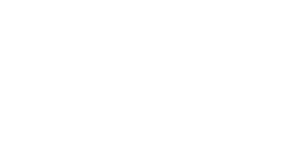

In [14]:
fig, ax = plt.subplots()
ax.set_xlim(0,500)
ax.set_ylim(50,150)
ax.grid()
line, = ax.plot([],[], '-')

def anim_frame(i):
    line.set_xdata(x)
    line.set_ydata(p[i])
    ax.set_title(f't = {i} days')
    ax.set_xlabel('x, m')
    ax.set_ylabel('p, atm')
    return line

animation = FuncAnimation(fig, func=anim_frame, frames=fr, interval=150, blit=True)
plt.close()

In [15]:
animation.save(name, writer='imagemagick')

MovieWriter imagemagick unavailable; using Pillow instead.


In [16]:
Image(url=name)